In [1]:
###IMPORT THE DATA FROM EXTRACTDATA.IPYNB###
##We're going to clean it up and create some new variables and plots##

import pandas as pd
import numpy as np
import cmlreaders as cml
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

new_df = pd.read_csv("IRT_data_updated.csv") #loaded in from ExtractData.ipynb
#new_df = pd.read_csv("IRT_data_updated_new.csv") #After cleaning up the data below, you can skip these steps and load in this file instead

In [2]:
####FIRST, LET'S CLEAN UP THE DATA####

###To save time, skip these steps and load in "IRT_data_updated_new.csv" in the previous step

print("Number of rows:", new_df.shape[0]) #how many rows to begin with

#However, there are some instrusions of -1 (very rare), that result in there being a few lists with 25 recalls
#So now I drop all recalls following a -1 intrusion; we missed this in ExtractData.ipynb

# Group by subject, session, and trial, then create a cumulative sum of intrusion
new_df['cumsum_intrusion'] = new_df.groupby(['subject', 'session', 'trial'])['intrusion'].cumsum()

# Filter out the rows following the first non-zero intrusion 
new_df = new_df[new_df['cumsum_intrusion'] > -1]

print("Number of rows:", new_df.shape[0]) #how many rows did we drop


####Recode OutputPosition, Total Recalls, and IRTs####

# Remove instances where serialpos is not in the range of 1 to 24
new_df = new_df[(new_df['serialpos'] >= 1) & (new_df['serialpos'] <= 24)]
print("Number of rows:", new_df.shape[0]) #how many rows did we drop

# Sort the DataFrame by subject, session, trial, and rectime
new_df.sort_values(by=['subject', 'session', 'trial', 'rectime'], inplace=True)

# Calculate the inter-response times (IRT) within each trial
new_df['IRT'] = new_df.groupby(['subject', 'session', 'trial'])['rectime'].diff()

# Identify the first recall event where IRT is NaN
first_nan_index = new_df[new_df['IRT'].isna()].groupby(['subject', 'session', 'trial']).head(1).index

# Exclude the first NaN IRT and renumber the OutputPosition variable starting from the second recall
new_df.loc[first_nan_index, 'OutputPosition'] = pd.NA
new_df['OutputPosition'] = new_df.groupby(['subject', 'session', 'trial'])['OutputPosition'].transform(lambda x: pd.Series(range(len(x)), index=x.index))

# Drop rows where OutputPosition is NaN
new_df.dropna(subset=['OutputPosition'], inplace=True)

# Convert IRT to seconds
new_df['IRT'] = new_df['IRT'] / 1000  

# Drop rows where IRT is zero
new_df = new_df[(new_df['IRT'] != 0)]

# Recompute total recall after filtering
new_df['total_recall'] = new_df.groupby(['subject', 'session', 'trial'])['OutputPosition'].transform('count') #+ 1


# Apply the log transformation to IRT (don't need this)
new_df['log_IRT'] = np.log(new_df['IRT'])

#Create IRT-1 and IRT-2
# Compute the previous IRT for lag=1, lag=2, and lag=3
for lag in [1, 2, 3]:
    new_df[f'IRT-{lag}'] = new_df.groupby(['subject', 'session', 'trial'])['IRT'].shift(lag)
    

###Don't need these log OP variables##
#Also add log of output position
# Compute the log of OutputPosition only when OutputPosition > 0
new_df['log_OutputPos'] = 0
new_df.loc[new_df['OutputPosition'] > 0, 'log_OutputPos'] = np.log(new_df['OutputPosition'])

# Alternative way to compute it, yields the same result. Compute the log of OutputPosition safely
new_df['log_OutputPos2'] = np.log1p(new_df['OutputPosition'] - 1)  # np.log1p(x) is log(1 + x), so np.log1p(OutputPosition - 1) is safe

#log(OP)^2
new_df['log_OutputPos_sq'] = new_df['log_OutputPos']**2

#log(OP)^3
new_df['log_OutputPos_cb'] = new_df['log_OutputPos']**3



##Remove lists where total recall is just 2 items or less as it's impossible to model
#sequential dependencies in these lists; you only get 1 IRT in these lists##

##Actually, in order to evaluate the chunking hypothesis, you need sequences of at least 3 recalls
#Thus, you need at minimum 5 total recalls, as the first 2 IRTs are not modeled b/c they require
#the IRTs on the previous 2 trials as predictors of the current trial IRT

new_df = new_df[new_df['total_recall'] >= 5]

print("Number of rows:", new_df.shape[0])

# Recode OutputPosition values from 23 to 22 only because there were so few of these values that they exert too much influence
new_df['OutputPosition_old'] = new_df['OutputPosition'] #save the old OP values
new_df['OutputPosition'] = new_df['OutputPosition'].replace(23, 22)
new_df['log_OutputPos'] = np.log(new_df['OutputPosition'])
new_df['log_OutputPos_sq'] = np.log(new_df['OutputPosition'])**2
new_df['log_OutputPos_cb'] = np.log(new_df['OutputPosition'])**3
# Drop rows where IRT is NaN (have to wait till after we do the OP by TR figure#
#new_df.dropna(subset=['IRT'], inplace=True)
#new_df[:20]
print("Number of rows:", new_df.shape[0])

Number of rows: 648158
Number of rows: 592631
Number of rows: 592415


/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Number of rows: 564555
Number of rows: 564555


/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
#Create a savepoint (you can also load this in the first block of code now and skip the previous step)
new_df.to_csv("IRT_data_updated_new.csv")

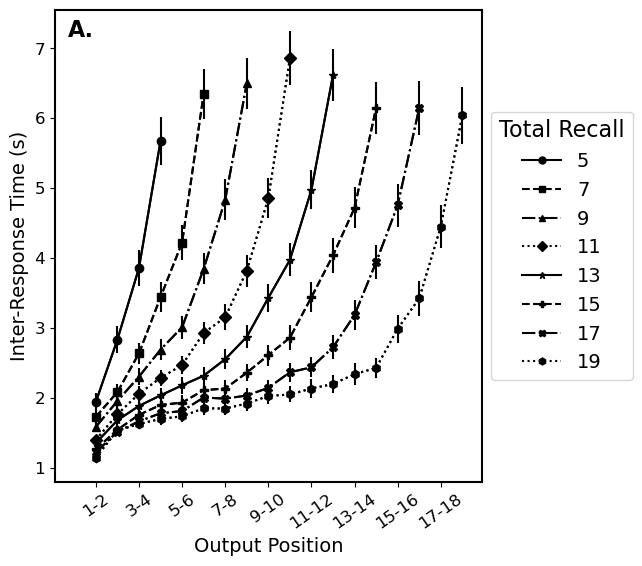

In [3]:
###PLOT OF IRT ~ OUTPUT_POS X TOTAL_REC###

# Create a plot showing the mean IRT at each output position for lists where the total recalls 
#were 5, 7, 9, 11, 13, 15, 17, or 19

total_recall_values = [5, 7, 9, 11, 13, 15, 17, 19]
filtered_df = new_df[new_df.groupby(['subject', 'session', 'trial'])['OutputPosition'].transform('count').isin(total_recall_values)]

# Calculate the mean IRT and standard error for each output position for each total recall value 
mean_irt = filtered_df.groupby(['total_recall', 'OutputPosition'])['IRT'].mean().reset_index()
stderr_irt = filtered_df.groupby(['total_recall', 'OutputPosition'])['IRT'].sem().reset_index()
stderr_irt['CI'] = 1.96 * stderr_irt['IRT'] #95% CI

# Plot the results
plt.figure(figsize=(5, 5.5))
line_styles = ['-', '--', '-.', ':']  # Define line styles for different total_recall_values
marker_shapes = ['o', 's', '^', 'D', '*', 'P', 'X', 'h']  # Define marker shapes for different total_recall_values
legend_handles = []  # Initialize legend handles
for i, total_recall in enumerate(total_recall_values):
    data = mean_irt[mean_irt['total_recall'] == total_recall]
    plt.plot(data['OutputPosition'], data['IRT'], color='black', linestyle=line_styles[i % len(line_styles)], label=f'{total_recall}')
    plt.errorbar(data['OutputPosition'], data['IRT'], yerr=stderr_irt[stderr_irt['total_recall'] == total_recall]['CI'], fmt=marker_shapes[i % len(marker_shapes)], color='black', linestyle=line_styles[i % len(line_styles)])
    #plt.errorbar(data['OutputPosition'], data['IRT'], yerr=stderr_irt[stderr_irt['total_recall'] == total_recall]['IRT'], fmt=marker_shapes[i % len(marker_shapes)], color='black', linestyle=line_styles[i % len(line_styles)])
    legend_handles.append(plt.Line2D([], [], color='black', linestyle=line_styles[i % len(line_styles)], marker=marker_shapes[i % len(marker_shapes)], markersize=5, label=f'{total_recall}'))

plt.xlabel('Output Position', fontsize=14)
plt.ylabel('Inter-Response Time (s)', fontsize=14)

# Add label "A" to appear inside the plot in the upper left corner, make it bold
plt.text(0.03, 0.98, "A.", transform=plt.gca().transAxes, fontsize=16, weight='bold', va='top')

# Adjust layout to prevent overlap
plt.tight_layout()

# Specify legend handles and labels to include both line and marker
plt.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5), title='Total Recall', title_fontsize=16, fontsize=14)  # Move legend to the right and remove the title
#plt.xticks(range(1, 18, 2))
plt.xticks(ticks=range(1, 18, 2), labels=[f'{i}-{i+1}' for i in range(1, 18, 2)], fontsize=12, rotation=35)
plt.yticks(fontsize=12)

# Increase the size of the box around the plot
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)

# Save the plot as an image
#plt.savefig('OutputTotalRecall_IRT.png', bbox_inches='tight')  # Save the plot with tight bounding box


plt.show()

In [8]:
###CREATE LAGS FOR LAG-CRL PLOT###

# Sort the DataFrame by subject, session, trial, and rectime
new_df.sort_values(by=['subject', 'session', 'trial', 'rectime'], inplace=True)

# Compute the lag variable within each trial where IRT is not NaN
new_df['lag'] = new_df.groupby(['subject', 'session', 'trial'])['serialpos'].diff().where(~new_df['IRT'].isna())


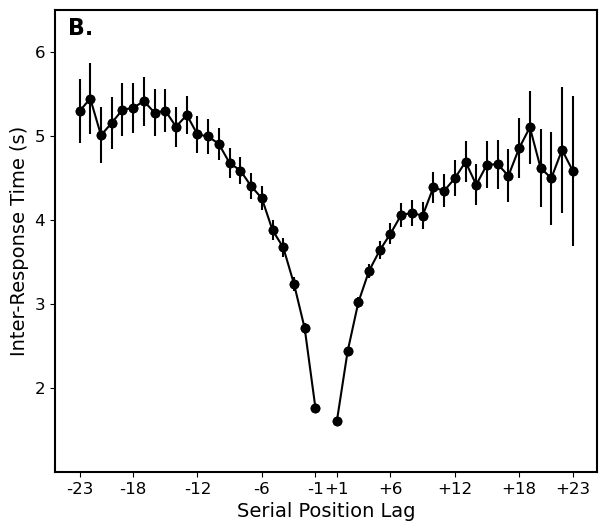

In [20]:
###PLOT OF IRTS ~ SERIAL POSITION LAG###

import matplotlib.pyplot as plt

# Calculate the mean IRT and standard error at each lag
mean_irt_by_lag = new_df.groupby('lag')['IRT'].mean().reset_index()
stderr_irt_by_lag = new_df.groupby('lag')['IRT'].sem().reset_index()
stderr_irt_by_lag['CI'] = 1.96 * stderr_irt_by_lag['IRT'] #95% CI

# Filter out the mean IRT values for lags -1 and +1 to +23
mean_irt_by_lag_subset = mean_irt_by_lag[(mean_irt_by_lag['lag'] >= -23) & (mean_irt_by_lag['lag'] <= 23) & (mean_irt_by_lag['lag'] != 0)]
stderr_irt_by_lag_subset = stderr_irt_by_lag[(stderr_irt_by_lag['lag'] >= -23) & (stderr_irt_by_lag['lag'] <= 23) & (stderr_irt_by_lag['lag'] != 0)]

# Split the data into two segments: lags from -23 to -1, and lags from +1 to +23
lag_neg = mean_irt_by_lag_subset[mean_irt_by_lag_subset['lag'] < 0]
lag_pos = mean_irt_by_lag_subset[mean_irt_by_lag_subset['lag'] > 0]

# Plot the mean IRT at each lag with error bars
plt.figure(figsize=(7, 6))
plt.plot(lag_neg['lag'], lag_neg['IRT'], marker='o', linestyle='-', color='black')  # Plot negative lags
plt.plot(lag_pos['lag'], lag_pos['IRT'], marker='o', linestyle='-', color='black')   # Plot positive lags
plt.errorbar(lag_neg['lag'], lag_neg['IRT'], yerr=stderr_irt_by_lag_subset[stderr_irt_by_lag_subset['lag'] < 0]['CI'], fmt='o', color='black')  # Plot negative lags
plt.errorbar(lag_pos['lag'], lag_pos['IRT'], yerr=stderr_irt_by_lag_subset[stderr_irt_by_lag_subset['lag'] > 0]['CI'], fmt='o', color='black')   # Plot positive lags

# Customize the plot
plt.xlabel('Serial Position Lag', fontsize=14)
plt.ylabel('Inter-Response Time (s)', fontsize=14)
# Add label "B" to appear inside the plot in the upper left corner, make it bold
plt.text(0.025, 0.985, "B.", transform=plt.gca().transAxes, fontsize=16, weight='bold', va='top')


# Format x-axis labels
# Set specific tick positions and labels for the x-axis
xticks = [-23, -18, -12, -6, -1, 1, 6, 12, 18, 23]
plt.xticks(xticks, [f'{i:+d}' if i > 0 else f'{i:d}' for i in xticks], fontsize=12)

plt.yticks([2, 3, 4, 5, 6],fontsize=12)
plt.ylim(1,6.5)

# Increase the size of the box around the plot
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)

# Save the plot as an image
plt.savefig('lag_IRT.png', bbox_inches='tight')  # Save the plot with tight bounding box


plt.show()


In [ ]:
###Create abs_lag_ln
new_df['abs_lag'] = np.abs(new_df['lag'])
new_df['abs_lag_ln'] = np.log(new_df['abs_lag'])

#Some descriptive statistics for some variables just to check that things look in order
print(new_df['serialpos'].describe())
print(new_df['intrusion'].describe())
print(new_df['lag'].describe())
print(new_df['abs_lag'].describe())
print(new_df['abs_lag_ln'].describe())

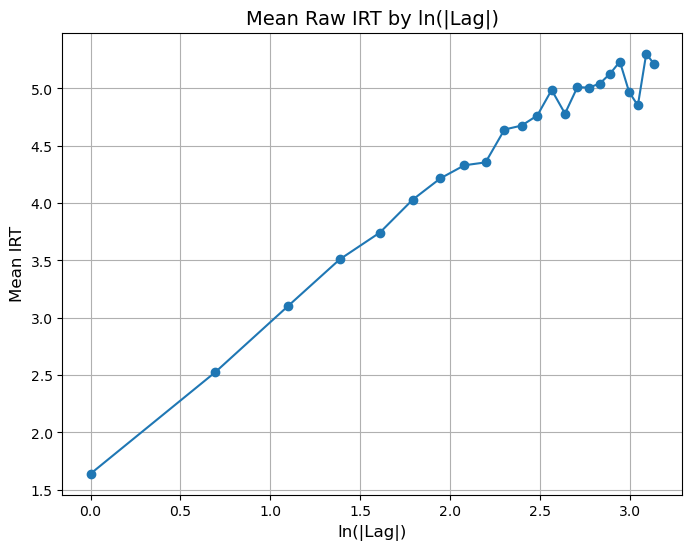

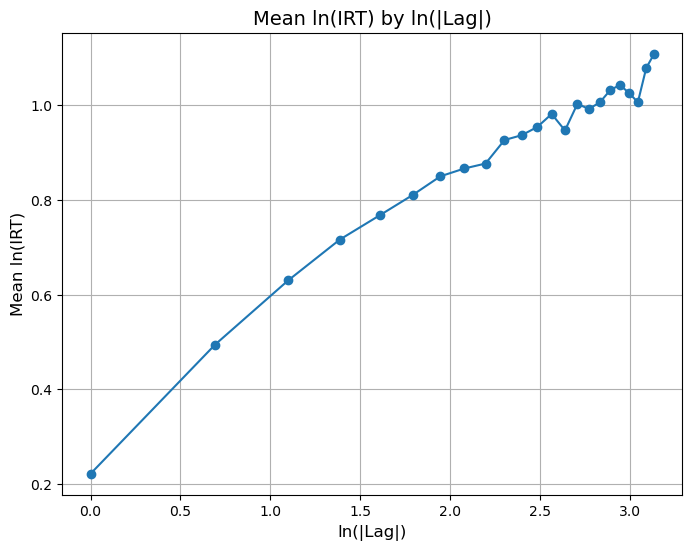

In [13]:
##Does computing the natural log of abs(lag) yield a relatively linear relation with IRTs?##

#The functional form othe ln(|lag|) on raw IRTs is relatively linear
grouped_data_lag = new_df.groupby('abs_lag_ln')['IRT'].mean().reset_index()

# Creating a plot
plt.figure(figsize=(8, 6))
plt.plot(grouped_data_lag['abs_lag_ln'], grouped_data_lag['IRT'], marker='o', linestyle='-')  # Line plot with points

plt.title('Mean Raw IRT by ln(|Lag|)', fontsize=14)
plt.xlabel('ln(|Lag|)', fontsize=12)
plt.ylabel('Mean IRT', fontsize=12)
plt.grid(True)  # Add gridlines for better readability
plt.show()

##How about with the log of IRTs?##

#The functional form othe ln(|lag|) on ln(IRT) is even more linear
grouped_data_lag2 = new_df.groupby('abs_lag_ln')['log_IRT'].mean().reset_index()

# Creating a plot
plt.figure(figsize=(8, 6))
plt.plot(grouped_data_lag2['abs_lag_ln'], grouped_data_lag2['log_IRT'], marker='o', linestyle='-')  # Line plot with points

plt.title('Mean ln(IRT) by ln(|Lag|)', fontsize=14)
plt.xlabel('ln(|Lag|)', fontsize=12)
plt.ylabel('Mean ln(IRT)', fontsize=12)
plt.grid(True)  # Add gridlines for better readability
plt.show()

In [21]:
#Need to update the data with the corrected lag values and the abs_lag and ln(abs_lag)
new_df.to_csv("IRT_data_updated_new.csv")

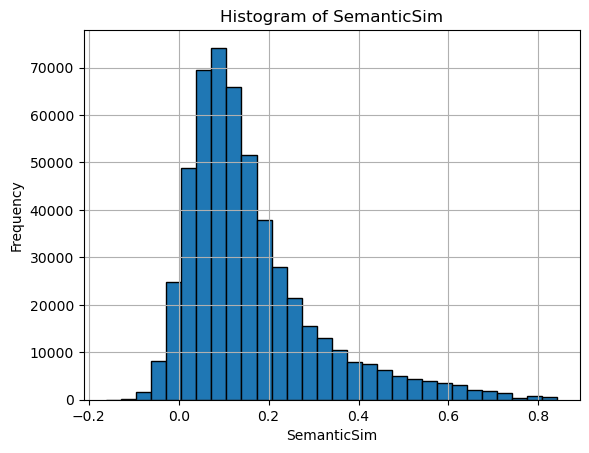

In [23]:
###Let's take a look at the Semantic Similarity values###

# Plotting the histogram of SemanticSim
plt.hist(new_df['SemanticSim'], bins=30, edgecolor='black')
plt.title('Histogram of SemanticSim')
plt.xlabel('SemanticSim')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [43]:
##Let's bin the SemanticSim variable##

# Create 10 bins with approximately equal numbers of data points
new_df['SemanticSimC_range'] = pd.qcut(new_df['SemanticSim'], q=10, duplicates='drop')

# Calculate the midpoints of the bins
new_df['SemanticSimC'] = new_df['SemanticSimC_range'].apply(lambda x: x.left + (x.right - x.left) / 2)

# Convert SemanticSimC to numeric
new_df['SemanticSimC'] = new_df['SemanticSimC'].astype(float)

# Adjust the midpoint for the highest bin to be the minimum value of the range
max_bin = new_df['SemanticSimC_range'].cat.categories[-1]
new_df.loc[new_df['SemanticSimC_range'] == max_bin, 'SemanticSimC'] = max_bin.left + 0.05

# Adjust the midpoint for the lowest bin to be the maximum value of the range
min_bin = new_df['SemanticSimC_range'].cat.categories[0]
new_df.loc[new_df['SemanticSimC_range'] == min_bin, 'SemanticSimC'] = min_bin.right


# Display the first few rows to verify
#print(new_df.head())

# Display the distribution of the binned data
print(new_df['SemanticSimC'].value_counts())




SemanticSimC
0.30450    52069
0.10960    51997
0.01950    51996
0.21700    51991
0.06175    51991
0.08555    51990
0.16950    51987
0.03455    51985
0.13650    51985
0.41300    51910
Name: count, dtype: int64


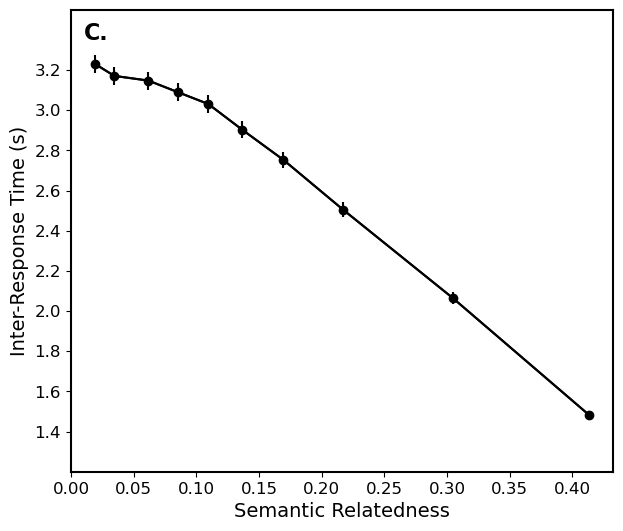

In [51]:
###PLOT OF SEMANTIC SIMILARITY EFFECTS ON IRT###

# Calculate the mean IRT for each level of SemanticSimC
mean_irt_by_simc = new_df.groupby('SemanticSimC')['IRT'].mean().reset_index()
stderr_irt = new_df.groupby(['SemanticSimC'])['IRT'].sem().reset_index()
stderr_irt['CI'] = 1.96 * stderr_irt['IRT'] #95% CI

# Plot the results
plt.figure(figsize=(7, 6))
plt.plot(mean_irt_by_simc['SemanticSimC'], mean_irt_by_simc['IRT'], marker='o', linestyle='-', color='black')
plt.errorbar(mean_irt_by_simc['SemanticSimC'], mean_irt_by_simc['IRT'], yerr=stderr_irt['CI'], color='black')

# Customize the plot
plt.xlabel('Semantic Relatedness', fontsize=14)
plt.ylabel('Inter-Response Time (s)', fontsize=14)
#plt.title('Mean IRT at Each Level of Semantic Similarity')
plt.xticks(fontsize=12)
plt.yticks(ticks=[1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2], fontsize=12)
plt.ylim(1.2, 3.5)

plt.text(0.025, 0.975, "C.", transform=plt.gca().transAxes, fontsize=16, weight='bold', va='top')

# Increase the size of the box around the plot
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)

# Save the plot as an image
plt.savefig('Semantic_IRT.png', bbox_inches='tight')  # Save the plot with tight bounding box


plt.show()

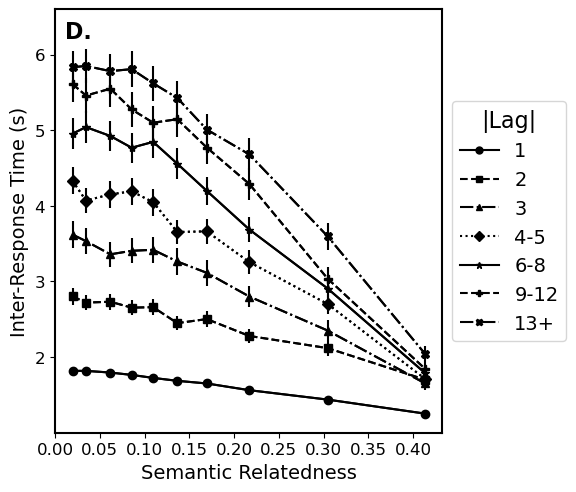

In [71]:
###Plot of Lag x Semantic Sim###

# Define the bins and labels for LagC
lag_bins = [-float('inf'), 1, 2, 3, 5, 8, 12, 24]
lag_labels = [1, 2, 3, 4, 6, 9, 13]

# Add a new column LagC to new_df based on the bins and labels
new_df['LagC'] = pd.cut(abs(new_df['lag']), bins=lag_bins, labels=lag_labels, include_lowest=True)

# Drop rows where the absolute value of lag exceeds 12
filtered_df = new_df[abs(new_df['lag']) <= 24].copy()

# Calculate the mean IRT for each level of SemanticSimC and LagC
mean_irt_by_simc_lagc = filtered_df.groupby(['SemanticSimC', 'LagC'])['IRT'].mean().reset_index()
stderr_irt = filtered_df.groupby(['SemanticSimC', 'LagC'])['IRT'].sem().reset_index()
stderr_irt['CI'] = 1.96 * stderr_irt['IRT'] #95% CI


# Get unique LagC values
lagc_values = mean_irt_by_simc_lagc['LagC'].unique()

# Plot the results for each LagC value
plt.figure(figsize=(5, 5.5))
line_styles = ['-', '--', '-.', ':', '-', '--', '-.']  # Define line styles for different total_recall_values
marker_shapes = ['o', 's', '^', 'D', '*', 'P', 'X', 'h']  # Define marker shapes for different total_recall_values
legend_handles = []  # Initialize legend handles
for lagc, line_style, marker_shape in zip(lagc_values, line_styles, marker_shapes):
    data = mean_irt_by_simc_lagc[mean_irt_by_simc_lagc['LagC'] == lagc]
    # Adjust legend label based on lagc value
    if lagc == 4:
        lag_label = '4-5'
    elif lagc == 6:
        lag_label = '6-8'
    elif lagc == 9:
        lag_label = '9-12'
    elif lagc == 13:
        lag_label = '13+'
    else:
        lag_label = str(lagc)    
    plt.plot(data['SemanticSimC'], data['IRT'], color='black', linestyle=line_style, label=f'LagC = {lag_label}')
    plt.errorbar(data['SemanticSimC'], data['IRT'], yerr=stderr_irt[stderr_irt['LagC'] == lagc]['CI'], fmt=marker_shape, color='black', linestyle=line_style)
    legend_handles.append(plt.Line2D([], [], color='black', linestyle=line_style, marker=marker_shape, markersize=5, label=f'{lag_label}'))


# Customize the plot
plt.xlabel('Semantic Relatedness', fontsize=14)
plt.ylabel('Inter-Response Time (s)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(ticks=[2, 3, 4, 5, 6], fontsize=12)  # Increase y-axis tick font size and set custom ticks
plt.ylim(1, 6.6)
#plt.yticks(fontsize=12)
#plt.yticks(ticks=[1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6])
plt.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5), title='|Lag|', title_fontsize=16, fontsize=14) 
plt.text(0.025, 0.975, "D.", transform=plt.gca().transAxes, fontsize=16, weight='bold', va='top')

# Increase the size of the box around the plot
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)

# Save the plot as an image
#plt.savefig('SimLag_IRT.png', bbox_inches='tight')  # Save the plot with tight bounding box


plt.show()


In [4]:
#Need to update the data with the corrected SemanticSimC values
new_df.to_csv("IRT_data_updated_new.csv")

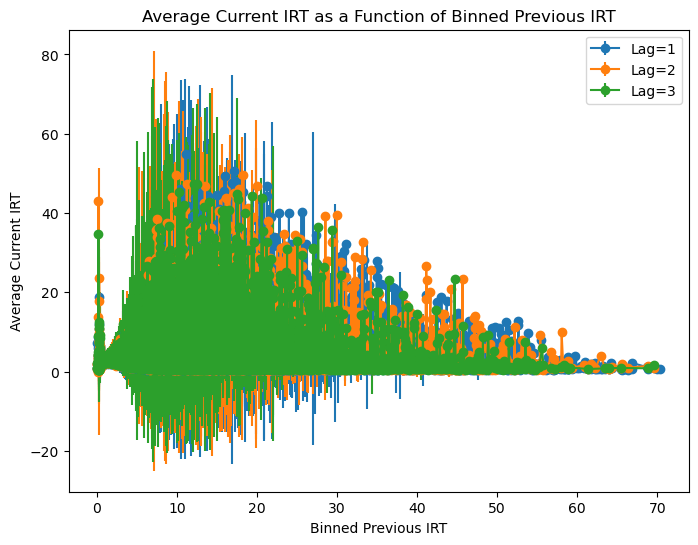

In [3]:
###Let's take a look at sequential dependencies###

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Step 1: Compute the previous IRT for lag=1, lag=2, and lag=3
for lag in [1, 2, 3]:
    new_df[f'prev_IRT_lag_{lag}'] = new_df.groupby(['subject', 'session', 'trial'])['IRT'].shift(lag)

# Step 2: Group by previous IRT for lag=1, lag=2, and lag=3 and calculate the average IRT and standard error
plt.figure(figsize=(8, 6))
for lag in [1, 2, 3]:
    grouped = new_df.groupby(f'prev_IRT_lag_{lag}')['IRT'].agg(['mean', 'sem'])
    plt.errorbar(grouped.index, grouped['mean'], yerr=1.96 * grouped['sem'], marker='o', linestyle='-', label=f'Lag={lag}')

plt.xlabel('Binned Previous IRT') #actually should be "raw" previous IRT
plt.ylabel('Average Current IRT')
plt.title('Average Current IRT as a Function of Binned Previous IRT') #it says "binned" but it should be "raw" previous IRT
plt.legend()
#plt.grid(True)
plt.show()


In [2]:
###Bin the IRT-1 and IRT-2 variables into 10 equal bins###

# Create 10 bins with approximately equal numbers of data points
new_df['IRT1_range'] = pd.qcut(new_df['IRT-1'], q=10, duplicates='drop')

# Calculate the midpoints of the bins
new_df['IRT1C'] = new_df['IRT1_range'].apply(lambda x: x.left + (x.right - x.left) / 2)

# Convert IRT1C to numeric
new_df['IRT1C'] = new_df['IRT1C'].astype(float)

# Adjust the midpoint for the highest bin to be the minimum value of the range
max_bin = new_df['IRT1_range'].cat.categories[-1]
new_df.loc[new_df['IRT1_range'] == max_bin, 'IRT1C'] = max_bin.left + 5


print(new_df['IRT1_range'].value_counts())

# Display the distribution of the binned data
print(new_df['IRT1C'].value_counts())


# Create 10 bins with approximately equal numbers of data points
new_df['IRT2_range'] = pd.qcut(new_df['IRT-2'], q=10, duplicates='drop')

# Calculate the midpoints of the bins
new_df['IRT2C'] = new_df['IRT2_range'].apply(lambda x: x.left + (x.right - x.left) / 2)

# Convert IRT2C to numeric
new_df['IRT2C'] = new_df['IRT2C'].astype(float)

# Adjust the midpoint for the highest bin to be the minimum value of the range
max_bin = new_df['IRT2_range'].cat.categories[-1]
new_df.loc[new_df['IRT2_range'] == max_bin, 'IRT2C'] = max_bin.left + 5


print(new_df['IRT2_range'].value_counts())

# Display the distribution of the binned data
print(new_df['IRT2C'].value_counts())

IRT1_range
(0.004, 0.688]     47776
(1.311, 1.541]     47570
(0.985, 1.137]     47554
(1.137, 1.311]     47533
(1.904, 2.635]     47532
(4.625, 70.384]    47532
(2.635, 4.625]     47528
(0.84, 0.985]      47501
(0.688, 0.84]      47435
(1.541, 1.904]     47360
Name: count, dtype: int64
IRT1C
0.3460    47776
1.4260    47570
1.0610    47554
1.2240    47533
2.2695    47532
9.6250    47532
3.6300    47528
0.9125    47501
0.7640    47435
1.7225    47360
Name: count, dtype: int64
IRT2_range
(1.121, 1.288]     43218
(0.683, 0.833]     43206
(0.024, 0.683]     43163
(1.835, 2.485]     43078
(2.485, 4.165]     43066
(4.165, 69.554]    43063
(0.833, 0.974]     43023
(1.288, 1.503]     43023
(1.503, 1.835]     42941
(0.974, 1.121]     42923
Name: count, dtype: int64
IRT2C
1.2045    43218
0.7580    43206
0.3535    43163
2.1600    43078
3.3250    43066
9.1650    43063
0.9035    43023
1.3955    43023
1.6690    42941
1.0475    42923
Name: count, dtype: int64


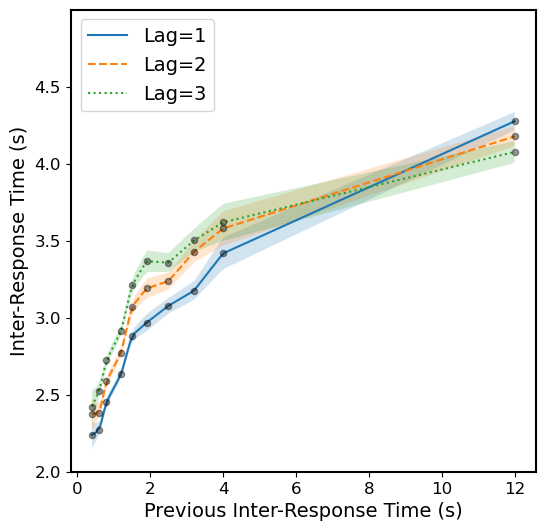

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

# Define the bins and corresponding binned values
bins = [0, 0.5, 0.75, 1, 1.4, 1.8, 2.1, 2.8, 3.8, 4.5, np.inf]
binned_values = [0.4, 0.6, 0.8, 1.2, 1.5, 1.9, 2.5, 3.2, 4, 12]

# Assuming 'new_df' is your DataFrame containing the free recall data

# Step 1: Compute the previous IRT for lag=1, lag=2, and lag=3
for lag in [1, 2, 3]:
    new_df[f'prev_IRT_lag_{lag}'] = new_df.groupby(['subject', 'session', 'trial'])['IRT'].shift(lag)

# Step 2: Bin the prev_IRT variables for lag=1, lag=2, and lag=3
for lag in [1, 2, 3]:
    new_df[f'binned_prev_IRT_lag_{lag}'] = pd.cut(new_df[f'prev_IRT_lag_{lag}'], bins=bins, labels=binned_values, right=False)

# Step 3: Group by binned_prev_IRT for lag=1, lag=2, and lag=3 and calculate the average IRT and standard error
plt.figure(figsize=(6, 6))
for idx, lag in enumerate([1, 2, 3]):
    grouped = new_df.groupby(f'binned_prev_IRT_lag_{lag}')['IRT'].agg(['mean', 'sem'])
    
    # Interpolate mean and confidence intervals
    x_interp = np.linspace(grouped.index.min(), grouped.index.max(), 100)
    f_mean = interp1d(grouped.index, grouped['mean'])
    f_lower = interp1d(grouped.index, grouped['mean'] - 1.96 * grouped['sem'])
    f_upper = interp1d(grouped.index, grouped['mean'] + 1.96 * grouped['sem'])
    
    # Define line styles for each lag
    line_styles = ['-', '--', ':']
    line_widths = [2.5, 2.5, 2.5]
    
    # Plot continuous lines and shaded confidence intervals with different line styles
    plt.plot(x_interp, f_mean(x_interp), label=f'Lag={lag}', linestyle=line_styles[idx], linewidth=line_widths[idx])
    plt.fill_between(x_interp, f_lower(x_interp), f_upper(x_interp), alpha=0.15)

    # Plot points representing mean at each binned value
    plt.scatter(grouped.index, f_mean(grouped.index), color='black', zorder=5, s=20, alpha=.4)

plt.xlabel('Previous Inter-Response Time (s)', fontsize=14)
plt.ylabel('Inter-Response Time (s)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(ticks=[2.0, 2.5, 3.0, 3.5, 4.0, 4.5], fontsize=12)  # Increase y-axis tick font size and set custom ticks
plt.ylim(2, 5)
plt.legend()
plt.legend(loc='upper left', fontsize=14) 

# Increase the size of the box around the plot
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)

# Save the plot as an image
plt.savefig('sequentialIRTs.png', bbox_inches='tight')  # Save the plot with tight bounding box

plt.show()

